In [1]:
%load_ext autoreload
%autoreload 2

# How to use ammonia-aqua system model from openACHP

To start, I'll import the modules I need ...

In [2]:
import ammonia1
import system_aqua1
import numpy as np
import matplotlib.pyplot as plt

## Boundary
Now I can create what I call a boundary for the chiller, in other words the specification of available resources, such as flow streams for bringing in or rejecting heat. I'll need that to evaluate heat exchangers later.

In [3]:
T_heat_reject = 305.
U = 100
xB = [400, 1, T_heat_reject, 3, T_heat_reject, 5, 285, 4, T_heat_reject, 0.15]
bdry = system_aqua1.makeBoundary(xB)
bdry

stream,T_inlet,mdot,cp
heat,400,1,4.179
absorberReject,305,3,4.179
condReject,305,5,4.179
cold,285,4,4.179
rectifierReject,305,0.15,4.179


In the output, we can see each of the flow streams defined where it goes into the chiller.

## Chiller
Now I'll specify and create a chiller. This is an output from one of my optimization runs, so it is supposed to be the "best" chiller with a total heat exchange inventory of 100 kW/K. The specification I've chosen is based on temperatures at a few key points, which allows me to solve the model procedurally, without an iterative solver.

In [7]:
xC = np.array([0.51284472, 277.97717012, 312.16427764, 313.6952877,
               310.24856734, 374.14020482])
ch = system_aqua1.makeChiller(xC)

I'll have to label the drawing to explain this in greater detail ...

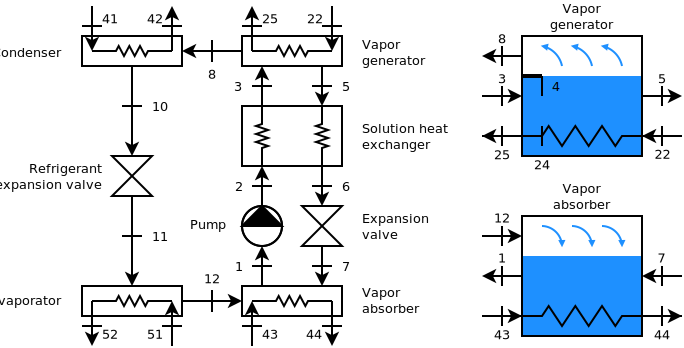

In [92]:
from IPython.display import HTML, SVG
filename='../img/Diagram_for_LIBR_update7.svg'
img = SVG(filename=filename)
display(img)

In [108]:
import xml.etree.ElementTree as ET
et = ET.parse(filename)

In [116]:
root = et.getroot()
for e in root.iterfind('{http://www.w3.org/2000/svg}:text'):
    for c in e.getchildren():
        display(c)
        if c.text == '1':
            c.text = 'new text'
# In progress ... this doesn't work well here
#display(ET.tostring(root))
#display(SVG(data=ET.tostring(root)))


We can see first a table of all the state points.

In [8]:
display(ch.getStateTable())

,T,P,x,h,s,u,v,Qu
rich_abs_outlet,310.249,4.87444,0.512028,-73.1846,0.395262,-73.7844,0.00123041,0
rich_pump_outlet,310.413,15.1396,0.512028,-71.6061,0.396279,-73.4682,0.00122993,-0.001
rich_shx_outlet,345.852,15.1396,0.512028,89.9885,0.889071,88.0334,0.00129135,-0.001
rich_gen_sat_liquid,351.91,15.1396,0.512028,118.322,0.970284,116.346,0.00130467,0
weak_gen_outlet,374.14,15.1396,0.39475,225.935,1.26082,224.014,0.00126878,0
weak_shx_outlet,329.938,15.1396,0.39475,25.493,0.691038,23.6904,0.00119066,-0.001
weak_exp_outlet,330.108,4.87444,0.39475,25.493,0.694743,24.911,0.00119402,7.84229e-06
gen_vapor_outlet,351.91,15.1396,0.988148,1424.52,4.5745,1268.66,0.102953,1
gen_reflux_inlet,351.91,15.1396,0.512027,118.318,0.970274,116.343,0.00130468,0
refrig_rect_outlet,313.695,15.1396,0.999869,1297.85,4.19504,1167.34,0.0862066,0.999598


We also get a table of the performance variables, such as heat flows (with a convention that positive indicates heat flowing into the chiller).

I'll also ask for some plots ...

C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


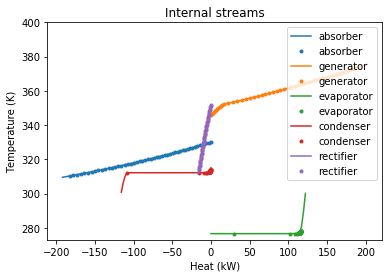

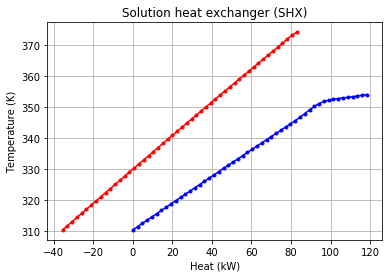

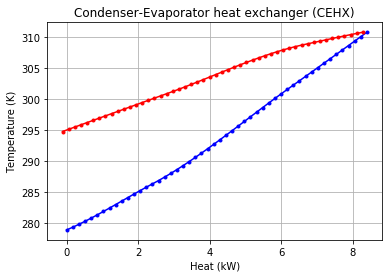

In [5]:
try:
    ch.display()
except RuntimeWarning as e:
    print(e)
plt.show()

The first one shows heat vs temperature curves for each of the heat exchangers facing the external streams. Temperature is measured on the internal side of the heat exchanger. These curves are used to calculate heat exchanger size vs. total heat rate.

The other two show some heat exchangers that are entirely internal, ie not facing the external streams. These were specified with effectiveness, so I don't need to calculate anything. But we can see that the curves are not linear because specific heats are changing or phase change is occuring through the process.

## System
Next I'll couple the boundary and chiller into a system object. I'll use it to evaluate the heat exchange parameters:

In [70]:
sys = system_aqua1.System(boundary=bdry, chiller=ch)
display(sys)

C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
C:\Users\nfette\Miniconda3\envs\openACHP\lib\site-packages\scipy\interpolate\_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


name,deltaT,epsilon,UA,Q
gen,5.60995,0.891216,14.9063,192.048
rect,8.66502,0.799757,1.04183,15.7864
abs,5.25365,0.735388,27.2915,182.886
cond,2.20854,0.967334,27.3363,110.508
evap,1.45034,0.982521,29.4333,116.323
total,0,0,100.009,0


- deltaT is the temperature difference at the pinch point.
- epsilon is the effectiveness
- UA is the heat exchanger overall heat transfer coefficient
- Q is the heat flow through the exchanger. In this setup, it is determined by the chiller specification.

## Interact
Okay, the next thing I want to do is show how we can interact with the model and manually adjust the specification. Jupyter has some useful widgets, but I had to get the ipywidgets package from different conda channel (conda-forge) to get a version compatible with the notebook extensions module (then enable it on command line).

In [56]:
import ipywidgets as widgets
print("widgets.__version__ = ",widgets.__version__)
import widgetsnbextension
print("widgetsnbextension.__version__ = ",widgetsnbextension.__version__)
print("Please check that you have compatible versions before proceeding.")

widgets.__version__ =  7.0.0
widgetsnbextension.__version__ =  3.0.2
Please check that you have compatible versions before proceeding.


This cell sets up the widgets ...

In [107]:
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual


common_opts = dict(
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)
w_m_rich = widgets.FloatSlider(
    value=0.5,
    min=0.1,
    max=2.0,
    step=0.05,
    description='m_rich',
    readout_format='.2f',
    **common_opts
)
w_T_evap = widgets.FloatSlider(
    value=278.0,
    min=275.0,
    max=285.0,
    step=0.1,
    description='T_evap',
    readout_format='.1f',
    **common_opts
)
w_T_cond = widgets.FloatSlider(
    value= 312.2,
    min=290,
    max=330,
    step=0.1,
    description='T_cond',
    readout_format='.1f',
    **common_opts
)
w_T_rect = widgets.FloatSlider(
    value=313.7,
    min=290.0,
    max=330.0,
    step=0.1,
    description='T_rect',
    readout_format='.1f',
    **common_opts
)
w_T_abs_outlet = widgets.FloatSlider(
    value=310.2,
    min=290.0,
    max=330.0,
    step=0.1,
    description='T_abs_outlet',
    readout_format='.1f',
    **common_opts
)
w_T_gen_outlet = widgets.FloatSlider(
    value=374.1,
    min=360.0,
    max=400.0,
    step=0.1,
    description='T_gen_outlet',
    readout_format='.1f',
    **common_opts
)

And this cell launches the interaction handler...

In [108]:
modes = ['chiller glob','chiller state points','chiller performance','chiller plots','system text']
def f(m_rich, T_evap, T_cond, T_rect, T_abs_outlet, T_gen_outlet, mode='system text'):
    xC = (m_rich, T_evap, T_cond, T_rect, T_abs_outlet, T_gen_outlet)
    ch = system_aqua1.makeChiller(xC)
    if mode == modes[0]:
        display(ch)
    elif mode == modes[1]:
        display(ch.getStateTable())
    elif mode == modes[2]:
        display(ch.getVariablesTable())
    elif mode == modes[3]:
        ch.display()
        plt.plot()
    elif mode == modes[4]:
        sys = system_aqua1.System(boundary=bdry, chiller=ch)
        display(sys)
        
#widgets.VBox(w_m_rich,w_T_evap,w_T_cond,w_T_rect,w_T_abs_outlet,w_T_gen_outlet)
interactive(f,
            m_rich=w_m_rich,
            T_evap=w_T_evap,
            T_cond=w_T_cond,
            T_rect=w_T_rect,
            T_abs_outlet=w_T_abs_outlet,
            T_gen_outlet=w_T_gen_outlet,
            mode=modes)

A Jupyter Widget

Now I can play with the inputs and see how the system responds ...

We could implement this as a web app not requiring the Jupyter Notebook, but at the moment the code is designed to run on server-side Python, so there would be some hosting cost for a reasonable amount of CPU time, or we would need our own server.

## That's it!